# Chapter 9: Data Science

(w_pacb45.pdf, page 277)

##  Dealing with data

(w_pacb45.pdf, page 281)

Typically, when you deal with data, this is the path...

In [1]:
# Some debug options

debug = False
if debug:
    import sys
    print(sys.version)
    print()
    print(sys.path)

### Setting up the notebook

(w_pacb45.pdf, page 282)

First things first, we need to set up the notebook.
This means imports and a bit of configuration.

In [2]:
import json
import calendar
import random
from datetime import date, timedelta

import faker
import numpy as np
from pandas import DataFrame
from delorean import parse
import pandas as pd

# make the graphs nicer
#
# d:\data\github\gmacario\learning-python\.lpenv\lib\site-packages\IPython\core\interactiveshell.py:2910: FutureWarning: 
# mpl_style had been deprecated and will be removed in a future version.
# Use `matplotlib.pyplot.style.use` instead.
#
#  exec(code_obj, self.user_global_ns, self.user_ns)
#
# pd.set_option('display.mpl_style', 'default')
# matplotlib.pyplot.style.use('default')

### Preparing the data

We want to achieve the following data structure...

In [3]:
fake = faker.Faker()
# print(fake)
# print(type(fake))

In [4]:
usernames = set()
usernames_no = 1000
# Populate the set with 1000 unique usernames
while len(usernames) < usernames_no:
        usernames.add(fake.user_name())
        
# print(type(usernames))  # <class 'set'>
# print(len(usernames))
# print(usernames)

# type(usernames)           # <class 'set'>
# list(usernames)
# len(usernames)            # 1000

In [5]:
def get_random_name_and_gender():
    male = random.random() > 0.6     # 60% of users will be female
    if male:
        return fake.name_male(), 'M'
    else:
        return fake.name_female(), 'F'

def get_users(username):
    users = []
    for username in usernames:
        name, gender = get_random_name_and_gender()
        user = {
            'username': username,
            'name': name,
            'gender': gender,
            'email': fake.email(),
            'age': fake.random_int(min=18, max=90),
            'address': fake.address(),
        }
        users.append(json.dumps(user))
    return users
    
# get_random_name_and_gender()
users = get_users(usernames)
# users[:3]

In [6]:
# campaign name format:
# InternalType_StartDate_EndDate_TargetAge_TargetGender_Currency

def get_type():
    # Just some gibberish internal codes
    types = ['AKX', 'BYU', 'GRZ', 'KTR']
    return random.choice(types)

# get_type()

def get_start_end_dates():
    duration = random.randint(1, 2 * 365)
    offset = random.randint(-365, 365)
    start = date.today() - timedelta(days=offset)
    end = start + timedelta(days=duration)
    
    def _format_date(date_):
        return date_.strftime("%Y%m%d")
    
    return _format_date(start), _format_date(end)

# get_start_end_dates()

def get_age():
    age = random.randint(20, 45)
    age -= age % 5
    diff = random.randint(5, 25)
    diff -= diff % 5
    return '{}-{}'.format(age, age + diff)

# get_age()

def get_gender():
    return random.choice(('M', 'F', 'B'))

# get_gender()

def get_currency():
    return random.choice(('GBP', 'EUR', 'USD'))

# [get_type(), get_start_end_dates(), get_gender(), get_currency()]

def get_campaign_name():
    separator = '_'
    type_ = get_type()
    start_end = separator.join(get_start_end_dates())
    age = get_age()
    gender = get_gender()
    currency = get_currency()
    return separator.join(
        (type_, start_end, age, gender, currency))

# get_campaign_name()
#
# Example output:
#
# 'KTR_20170526_20190322_35-40_F_GBP'

In [7]:
def get_campaign_data():
    name = get_campaign_name()
    budget = random.randint(10**3, 10**6)
    spent = random.randint(10**2, budget)
    clicks = int(random.triangular(10**2, 10**5, 0.2 * 10**5))
    impressions = int(random.gauss(0.5 * 10**6, 2))
    return {
        'cmp_name': name,
        'cmp_bgt': budget,
        'cmp_spent': spent,
        'cmp_clicks': clicks,
        'cmp_impr': impressions,
    }

# get_campaign_data()
#
# Example output:
#
# {'cmp_bgt': 733642,
#  'cmp_clicks': 25152,
#  'cmp_impr': 500000,
#  'cmp_name': 'AKX_20180917_20200915_35-40_F_USD',
#  'cmp_spent': 690411}

Now that we have the data, it's time to put it all together:

In [8]:
def get_data(users):
    data = []
    for user in users:
        campaigns = [get_campaign_data()
                    for _ in range(random.randint(2, 8))]
        data.append({
            'user': user,
            'campaigns': campaigns,
        })
    return data

# users[:2]
# print(get_data(users))

### Cleaning the data

(w_pacb45.pdf, page 287)

Let's start cleaning the data

In [9]:
rough_data = get_data(users)
rough_data[:2]   # Let's take a peek

[{'campaigns': [{'cmp_bgt': 103673,
    'cmp_clicks': 22015,
    'cmp_impr': 499997,
    'cmp_name': 'AKX_20170914_20180411_40-60_M_USD',
    'cmp_spent': 26342},
   {'cmp_bgt': 387346,
    'cmp_clicks': 33702,
    'cmp_impr': 499996,
    'cmp_name': 'BYU_20181012_20190418_35-45_M_USD',
    'cmp_spent': 110438},
   {'cmp_bgt': 610452,
    'cmp_clicks': 69392,
    'cmp_impr': 500000,
    'cmp_name': 'AKX_20170408_20190228_20-30_F_USD',
    'cmp_spent': 157387},
   {'cmp_bgt': 687352,
    'cmp_clicks': 60517,
    'cmp_impr': 500001,
    'cmp_name': 'KTR_20180704_20181111_35-45_M_EUR',
    'cmp_spent': 68078},
   {'cmp_bgt': 252896,
    'cmp_clicks': 68523,
    'cmp_impr': 499999,
    'cmp_name': 'KTR_20180827_20191216_30-35_B_USD',
    'cmp_spent': 34247},
   {'cmp_bgt': 425513,
    'cmp_clicks': 48862,
    'cmp_impr': 499998,
    'cmp_name': 'AKX_20170120_20180607_40-45_M_GBP',
    'cmp_spent': 296555},
   {'cmp_bgt': 564729,
    'cmp_clicks': 48245,
    'cmp_impr': 499999,
    'cmp_nam

So, we now start working with it

In [10]:
data = []
for datum in rough_data:
    for campaign in datum['campaigns']:
        campaign.update({'user': datum['user']})
        data.append(campaign)

data[:2]               # let's take another peek

[{'cmp_bgt': 103673,
  'cmp_clicks': 22015,
  'cmp_impr': 499997,
  'cmp_name': 'AKX_20170914_20180411_40-60_M_USD',
  'cmp_spent': 26342,
  'user': '{"username": "alisonodom", "name": "Emily Davis", "gender": "F", "email": "mkim@perry.org", "age": 80, "address": "PSC 0918, Box 6273\\nAPO AA 06270-6718"}'},
 {'cmp_bgt': 387346,
  'cmp_clicks': 33702,
  'cmp_impr': 499996,
  'cmp_name': 'BYU_20181012_20190418_35-45_M_USD',
  'cmp_spent': 110438,
  'user': '{"username": "alisonodom", "name": "Emily Davis", "gender": "F", "email": "mkim@perry.org", "age": 80, "address": "PSC 0918, Box 6273\\nAPO AA 06270-6718"}'}]

### Creating the DataFrame

(w_pacb45.pdf, page 289)

Now it's time to create the `DataFrame`:

In [11]:
df = DataFrame(data)
df.head()

#print(df.head())
#df
#print(df)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
0,103673,22015,499997,AKX_20170914_20180411_40-60_M_USD,26342,"{""username"": ""alisonodom"", ""name"": ""Emily Davi..."
1,387346,33702,499996,BYU_20181012_20190418_35-45_M_USD,110438,"{""username"": ""alisonodom"", ""name"": ""Emily Davi..."
2,610452,69392,500000,AKX_20170408_20190228_20-30_F_USD,157387,"{""username"": ""alisonodom"", ""name"": ""Emily Davi..."
3,687352,60517,500001,KTR_20180704_20181111_35-45_M_EUR,68078,"{""username"": ""alisonodom"", ""name"": ""Emily Davi..."
4,252896,68523,499999,KTR_20180827_20191216_30-35_B_USD,34247,"{""username"": ""alisonodom"", ""name"": ""Emily Davi..."


In [12]:
df.count()

cmp_bgt       5044
cmp_clicks    5044
cmp_impr      5044
cmp_name      5044
cmp_spent     5044
user          5044
dtype: int64

In [13]:
df.describe()

,cmp_bgt,cmp_clicks,cmp_impr,cmp_spent
count,5044.000000,5044.000000,5044.000000,5044.000000
mean,501847.527557,40146.830293,499999.489294,250816.894726
std,287327.849612,21528.796731,2.039099,218825.248983
min,1050.000000,500.000000,499992.000000,133.000000
25%,256871.000000,22750.000000,499998.000000,67923.250000
50%,502269.500000,36657.500000,499999.000000,188671.500000
75%,749798.250000,55548.500000,500001.000000,384709.000000
max,999780.000000,98803.000000,500007.000000,979419.000000


Let's see which are the three campaigns with the highest and lowest budgets.

In [14]:
df.sort_values(by=['cmp_bgt'], ascending=False).head(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
2873,999780,58135,500000,BYU_20180813_20191229_30-45_B_USD,841332,"{""username"": ""scott34"", ""name"": ""Jessica Bradl..."
226,999675,36936,499997,KTR_20170423_20170727_20-30_B_EUR,434859,"{""username"": ""nicholasrobinson"", ""name"": ""Dian..."
1745,999441,79360,499998,AKX_20180203_20181016_35-50_B_USD,442622,"{""username"": ""barbermelissa"", ""name"": ""Michael..."


In [15]:
df.sort_values(by=['cmp_bgt'], ascending=False).tail(3)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user
680,1373,15577,499999,KTR_20170622_20180113_40-55_B_EUR,816,"{""username"": ""laurenoneill"", ""name"": ""Shelby B..."
1924,1135,37741,500001,GRZ_20170302_20170607_20-25_M_USD,133,"{""username"": ""candace27"", ""name"": ""John Keith""..."
3288,1050,15029,499997,AKX_20180311_20190529_45-60_F_USD,291,"{""username"": ""pamela16"", ""name"": ""Tamara Jones..."


#### Unpacking the campaign name

(w_pacb45.pdf, page 291)

Now it's time to increase the complexity up a bit.

In [16]:
def unpack_campaign_name(name):
    """Very optimistic method, assumes data in campaign name
    is always in good state"""
    type_, start, end, age, gender, currency = name.split('_')
    start = parse(start).date
    end = parse(end).date
    return type_, start, end, age, gender, currency

campaign_data = df['cmp_name'].apply(unpack_campaign_name)
campaign_cols = [
    'Type', 'Start', 'End', 'Age', 'Gender', 'Currency'
]
campaign_df = DataFrame(
    campaign_data.tolist(), columns=campaign_cols, index=df.index
)
campaign_df.head(3)

,Type,Start,End,Age,Gender,Currency
0,AKX,2017-09-14,2018-11-04,40-60,M,USD
1,BYU,2018-12-10,2019-04-18,35-45,M,USD
2,AKX,2017-08-04,2019-02-28,20-30,F,USD


In [17]:
# raise ValueError if doing `df = df.join(campaign_df)`

df2 = df
df2 = df2.join(campaign_df)
df2.head(4)

,cmp_bgt,cmp_clicks,cmp_impr,cmp_name,cmp_spent,user,Type,Start,End,Age,Gender,Currency
0,103673,22015,499997,AKX_20170914_20180411_40-60_M_USD,26342,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",AKX,2017-09-14,2018-11-04,40-60,M,USD
1,387346,33702,499996,BYU_20181012_20190418_35-45_M_USD,110438,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",BYU,2018-12-10,2019-04-18,35-45,M,USD
2,610452,69392,500000,AKX_20170408_20190228_20-30_F_USD,157387,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",AKX,2017-08-04,2019-02-28,20-30,F,USD
3,687352,60517,500001,KTR_20180704_20181111_35-45_M_EUR,68078,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",KTR,2018-04-07,2018-11-11,35-45,M,EUR


And after the join, we take a peek, hoping to seee matching data:

In [18]:
df2[['cmp_name'] + campaign_cols].head(3)

,cmp_name,Type,Start,End,Age,Gender,Currency
0,AKX_20170914_20180411_40-60_M_USD,AKX,2017-09-14,2018-11-04,40-60,M,USD
1,BYU_20181012_20190418_35-45_M_USD,BYU,2018-12-10,2019-04-18,35-45,M,USD
2,AKX_20170408_20190228_20-30_F_USD,AKX,2017-08-04,2019-02-28,20-30,F,USD


#### Unpacking the user data

(w_pacb45.pdf, page 293)

In [19]:
def unpack_user_json(user):
    """Very optimistic as well, expects user objects
    to have all attributes"""
    user = json.loads(user.strip())
    return [
        user['username'],
        user['email'],
        user['name'],
        user['gender'],
        user['age'],
        user['address'],
    ]

#df2['user']

user_data = df2['user'].apply(unpack_user_json)
# user_data

user_cols = ['username', 'email', 'name', 'gender', 'age', 'address']
# user_cols

user_df = DataFrame(
    user_data.tolist(), columns=user_cols, index=df2.index
)
user_df

,username,email,name,gender,age,address
0,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
1,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
2,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
3,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
4,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
5,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
6,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
7,alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
8,caleb62,jason60@williams.com,David Miller,M,85,"667 Jeffrey Road Apt. 248\nWest Jessica, CT 78..."
9,caleb62,jason60@williams.com,David Miller,M,85,"667 Jeffrey Road Apt. 248\nWest Jessica, CT 78..."


In [20]:
df3 = df2
df3 = df3.join(user_df)

print('df.count()=', df.count())
print('df2.count()=', df2.count())
print('df3.count()=', df3.count())

df3[['user'] + user_cols].head(2)


df.count()= cmp_bgt       5044
cmp_clicks    5044
cmp_impr      5044
cmp_name      5044
cmp_spent     5044
user          5044
dtype: int64
df2.count()= cmp_bgt       5044
cmp_clicks    5044
cmp_impr      5044
cmp_name      5044
cmp_spent     5044
user          5044
Type          5044
Start         5044
End           5044
Age           5044
Gender        5044
Currency      5044
dtype: int64
df3.count()= cmp_bgt       5044
cmp_clicks    5044
cmp_impr      5044
cmp_name      5044
cmp_spent     5044
user          5044
Type          5044
Start         5044
End           5044
Age           5044
Gender        5044
Currency      5044
username      5044
email         5044
name          5044
gender        5044
age           5044
address       5044
dtype: int64


,user,username,email,name,gender,age,address
0,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"
1,"{""username"": ""alisonodom"", ""name"": ""Emily Davi...",alisonodom,mkim@perry.org,Emily Davis,F,80,"PSC 0918, Box 6273\nAPO AA 06270-6718"


In [21]:
better_columns = [
    'Budget', 'Clicks', 'Impressions',
    'cmp_name', 'Spent', 'user',
    'Type', 'Start', 'End',
    'Target Age', 'Target Gender', 'Currency',
    'Username', 'Email', 'Name',
    'Gender', 'Age', 'Address'
]
df3.columns = better_columns
# df3

Completing the `datasetNext` step will be to add some extra columns.

In [22]:
def calculate_extra_columns(df):
    # Click Through Rate
    df['CTR'] = df['Clicks'] / df ['Impressions']
    # Cost Per Click
    df['CPC'] = df['Spent'] / df ['Clicks']
    # Cost Per Impression
    df['CPI'] = df['Spent'] / df ['Impressions']

calculate_extra_columns(df3)
# df3

We can take a look at the results by filtering on the relevant columns and calling `head`.

In [23]:
df3[['Spent', 'Clicks', 'Impressions',
     'CTR', 'CPC', 'CPI']].head(3)

,Spent,Clicks,Impressions,CTR,CPC,CPI
0,26342,22015,499997,0.044030,1.196548,0.052684
1,110438,33702,499996,0.067405,3.276898,0.220878
2,157387,69392,500000,0.138784,2.268086,0.314774


Now, I want to verify the accuracy of the results manually for the first row:

In [24]:
clicks = df3['Clicks'][0]
impressions = df3['Impressions'][0]
spent = df3['Spent'][0]
CTR = df3['CTR'][0]
CPC = df3['CPC'][0]
CPI = df3['CPI'][0]

print('CTR:', CTR, clicks / impressions)
print('CPC:', CPC, spent / clicks)
print('CPI:', CPI, spent / impressions)

CTR: 0.0440302641816 0.0440302641816
CPC: 1.19654780831 1.19654780831
CPI: 0.0526843161059 0.0526843161059


(w_pacb45.pdf, page 296)

We are almost done with out `DataFrame`.
All we are missing now is a column that tells us the duration of the campaign and a column that tells us which day of the week corresponds to the start date of each campaign.
This allows me to expand on how to play with date objects.

In [25]:
def get_day_of_the_week(day):
    number_to_day = dict(enumerate(calendar.day_name, 1))
    return number_to_day[day.isoweekday()]

def get_duration(row):
    return (row['End'] - row['Start']).days

#get_day_of_the_week(date.today())
df4 = df3
df4['Day of Week'] = df4['Start'].apply(get_day_of_the_week)
df4['Duration'] = df4.apply(get_duration, axis=1)

#df4

(w_pacb45.pdf, page 297)

We can verify the results very easily, as shown here

In [26]:
df4[['Start', 'End', 'Duration', 'Day of Week']].head(3)

,Start,End,Duration,Day of Week
0,2017-09-14,2018-11-04,416,Thursday
1,2018-12-10,2019-04-18,129,Monday
2,2017-08-04,2019-02-28,573,Friday


#### Cleaning everything up

(w_pacb45.pdf, page 297)

In [27]:
final_columns = [
    'Type', 'Start', 'End', 'Duration', 'Day of Week', 'Budget',
    'Currency', 'Clicks', 'Impressions', 'Spent', 'CTR', 'CPC',
    'CPI', 'Target Age', 'Target Gender', 'Username', 'Email',
    'Name', 'Gender', 'Age'
]
df5 = df4[final_columns]

#df5

Now our DataFrame is clean and ready for us to inspect.

### Saving the DataFrame to a file

(w_pacb45.pdf, page 298)

In [28]:
df5.to_csv('df5.csv')

In [29]:
df5.to_json('df5.json')

In [30]:
df5.to_excel('df5.xls')

So, it's extremely easy to save a DataFrame in many different formats, and the good news is that the opposite is also true: ...

### Visualizing the results

(w_pacb45.pdf, page 299)

TODO

In [31]:
%matplotlib inline

In [32]:
import pylab
pylab.rcParams.update({'font.family': 'serif'})

In [33]:
df5.describe()

,Duration,Budget,Clicks,Impressions,Spent,CTR,CPC,CPI,Age
count,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000,5044.000000
mean,365.663561,501847.527557,40146.830293,499999.489294,250816.894726,0.080294,9.842235,0.501634,53.581086
std,248.729061,287327.849612,21528.796731,2.039099,218825.248983,0.043058,20.416241,0.437651,21.070761
min,-327.000000,1050.000000,500.000000,499992.000000,133.000000,0.001000,0.002286,0.000266,18.000000
25%,176.000000,256871.000000,22750.000000,499998.000000,67923.250000,0.045500,1.816881,0.135847,35.000000
50%,368.000000,502269.500000,36657.500000,499999.000000,188671.500000,0.073315,5.131799,0.377343,53.000000
75%,558.000000,749798.250000,55548.500000,500001.000000,384709.000000,0.111097,11.545623,0.769421,72.000000
max,1061.000000,999780.000000,98803.000000,500007.000000,979419.000000,0.197605,647.690000,1.958854,90.000000


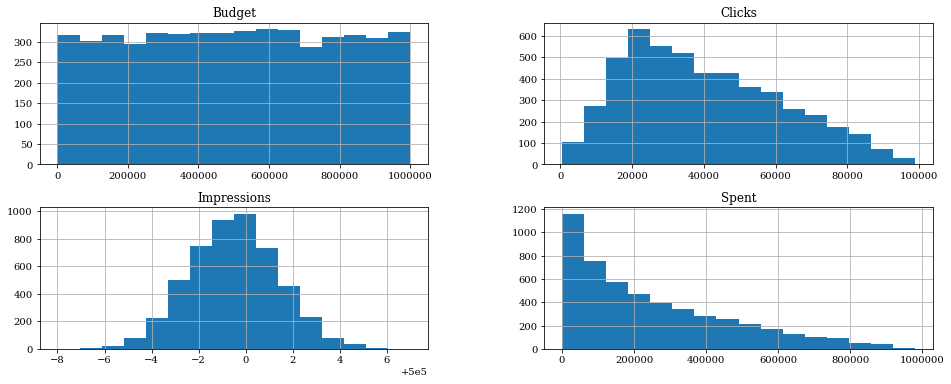

In [34]:
df5[['Budget', 'Spent', 'Clicks', 'Impressions']]\
    .hist(bins=16, figsize=(16, 6));

(w_pacb45.pdf, page 302)

Let's plot out the measures we calculated:

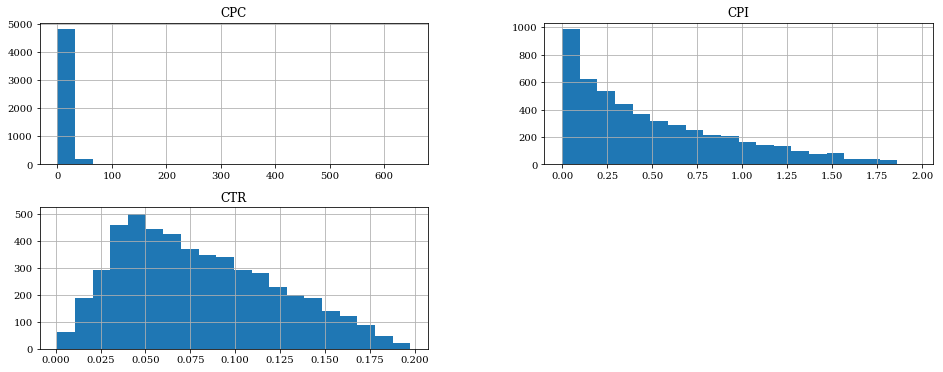

In [35]:
df5[['CTR', 'CPC', 'CPI']]\
    .hist(bins=20, figsize=(16, 6));

(w_pacb45.pdf, page 302)

Now, all this is nice, but if you wanted to analyze only a particular segment of the data, how would you do it?

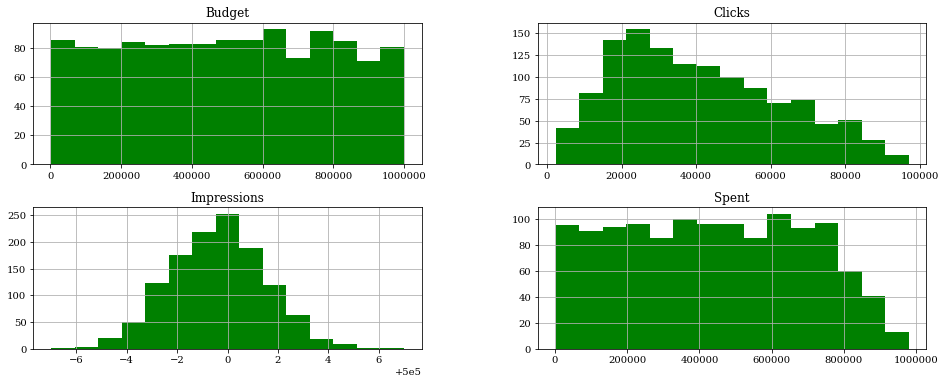

In [36]:
mask = (df5.Spent > 0.75 * df5.Budget)
df5[mask][['Budget', 'Spent', 'Clicks', 'Impressions']]\
    .hist(bins=15, figsize=(16, 6), color='g');

(w_pacb45.pdf, page 303)

Let's now ask for something different. How about the measure of spent, click, and impressions grouped by day of week?

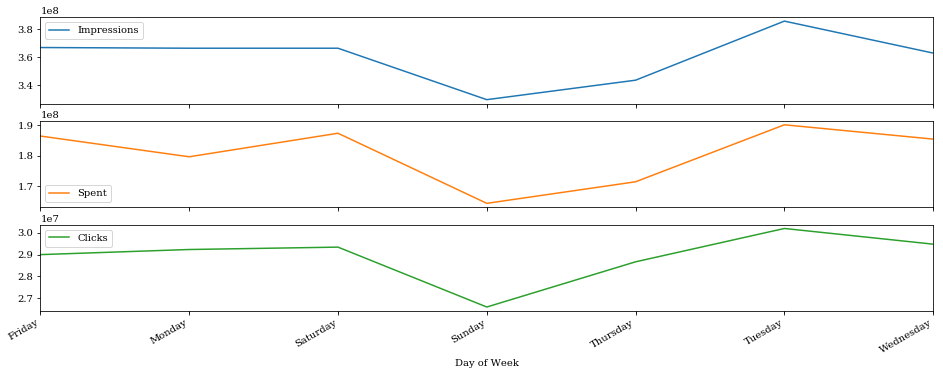

In [37]:
df5_weekday = df5.groupby(['Day of Week']).sum()
df5_weekday[
    ['Impressions', 'Spent', 'Clicks']].plot(
     figsize=(16, 6), subplots=True);

(w_pacb45.pdf, page 304)

Let's finish this presentation with a couple more things

In [38]:
# TODO: #38

## Where do we go from here?

TODO

## Summary

TODO

# TODO

In [39]:
#%lsmagic
#%pwd
#%ls
#%pdb
#?range
#?%lsmagic
#%env
#?print